# Hypothesis test

Import delle librerie

In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize, stats
from scipy.optimize import fmin
from scipy.interpolate import interp1d
from matplotlib import *
from mpl_toolkits.mplot3d import Axes3D


Recupero delle informazioni e degli istogrammi

In [2]:
def getHistoInfo(fileName, histoName):
    """
    Simple function that just open root file and retun numpy list
    
    Parameters
    ----------
    fileName : str
        The name of file
    histoName : str
        The name of histogram
    
    Returns
    ----------
    dim-2 numpy array (bin content, bin edge)
        
    """
    file_ = uproot.open(fileName)
    histo = file_[histoName].to_numpy()
    return histo

def getEvents(histo, lumi, min_, max_, isData=False):
    """
    Return yields and bin arrays in a given range
    
    Parameters
    ----------
    histo : 
        dim-2 numpy array of histogram
    lumi : double
        luminosity
    min_, max_ : double
        minimum and maximum of interval
    isData : bool
        If True lumi is not considered
    
    Returns
    ----------
    Yields and bin numpy arrays in a given interval
        
    """
    mask_bin = (histo[1] >=min_) & (histo[1] <=max_)
    mask_sel = (histo[1][:-1] >=min_) & (histo[1][:-1] <max_)

    yields = histo[0][mask_sel]
    if not isData: yields = yields * lumi
    bins = histo[1][mask_bin]

    return yields, bins

def plotStack(signalHisto, bkgHisto, dataHisto, lumi, min_, max_,
             labelExp = 'ATLAS Open Data', colors = ['blue','red'], text = 'ATLAS' ):

    signal_yield, bins = getEvents(signalHisto, lumi, min_, max_)
    bkg_yield = getEvents(bkgHisto, lumi, min_, max_)[0]
    data_yield = getEvents(dataHisto, lumi, min_, max_, isData=True)[0]

    #print(bins)
    stack_w = np.column_stack((bkg_yield, signal_yield))
    stack = np.column_stack((bins[:-1], bins[:-1]))


    #Plot stack
    labels=['Bkg', 'Higgs']
    
    fig, ax = plt.subplots()
    fig.set_size_inches((7,7))

    bin_centres =  (bins[1:] + bins[:-1]) / 2
    err = np.sqrt(data_yield)

    ax.errorbar(bin_centres, data_yield, yerr=err, fmt='o', color='black', label='Data')
    ax.hist(stack,  label=labels, stacked=True, bins=bins, weights = stack_w, color=colors)
    maxY=ax.get_ylim()[1]*1.5
    ax.set_ylabel(r"Events", loc="top", fontsize=15)
    ax.set_xlabel(r"$m_{4l}$ [GeV]", loc="right", fontsize=15)
    ax.tick_params(which="both", direction="in", length=6, width=1)
    ax.set_ylim(0, maxY)
    ax.text(min_, maxY*0.95, labelExp, weight="bold",fontsize=15)
    #ax.text(min_, maxY*0.85, r"$\sqrt{s}$" + " = 13 TeV," + " $\int$Ldt = " + " 10 fb" + r"$^{-1}$",fontsize=15)
    if 'ATLAS' in  text: ax.text(min_, maxY*0.85, r"$\sqrt{s}$" + " = 13 TeV," + " $\int$Ldt = " + " 10 fb" + r"$^{-1}$",fontsize=15)
    if 'CMS' in  text: ax.text(min_, maxY*0.85, r"$\sqrt{s}$" + " = 8 TeV," + " $\int$Ldt = " + " 11.6 fb" + r"$^{-1}$",fontsize=15)

    ax.legend(fontsize=15, frameon=False)
    

<>:80: SyntaxWarning: invalid escape sequence '\i'
<>:81: SyntaxWarning: invalid escape sequence '\i'
<>:80: SyntaxWarning: invalid escape sequence '\i'
<>:81: SyntaxWarning: invalid escape sequence '\i'
/var/folders/zc/fgnlm66n7z5ghy8czs88fpkr0000gn/T/ipykernel_90544/2514765899.py:80: SyntaxWarning: invalid escape sequence '\i'
  if 'ATLAS' in  text: ax.text(min_, maxY*0.85, r"$\sqrt{s}$" + " = 13 TeV," + " $\int$Ldt = " + " 10 fb" + r"$^{-1}$",fontsize=15)
/var/folders/zc/fgnlm66n7z5ghy8czs88fpkr0000gn/T/ipykernel_90544/2514765899.py:81: SyntaxWarning: invalid escape sequence '\i'
  if 'CMS' in  text: ax.text(min_, maxY*0.85, r"$\sqrt{s}$" + " = 8 TeV," + " $\int$Ldt = " + " 11.6 fb" + r"$^{-1}$",fontsize=15)


Recuperiamo le informazioni sull'istogramma `mass_four_lep` per le simulazioni MC di segnale e fondo, e per i dati. La luminosità integrata corrisponde a 10 fb$^{.1}$. Usiamo la funzione `plotStack` per visualizzare gli istogrammi

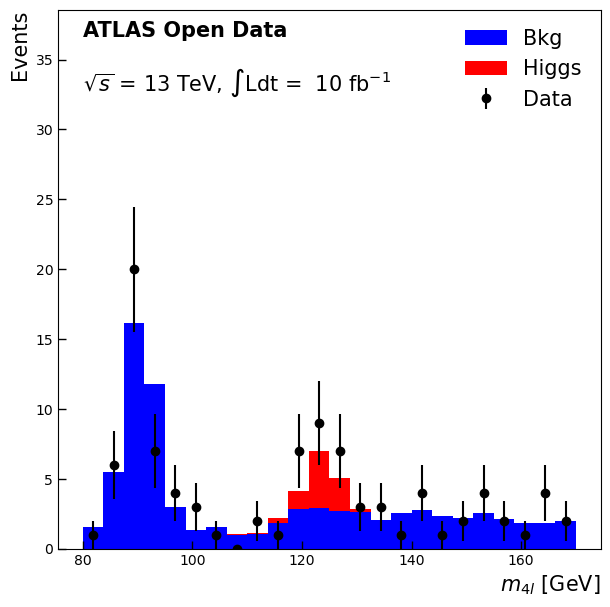

In [3]:
histoName = 'mass_four_lep'
lumi = 10060

signalHisto = getHistoInfo('inputH4lep/Higgs.root', histoName)
dataHisto = getHistoInfo('inputH4lep/data.root', histoName)
bkgHisto = getHistoInfo('inputH4lep/Bkg.root', histoName)

plotStack(signalHisto, bkgHisto, dataHisto, lumi, 80, 170)



```{tip} Esercizio
:class: show
- Qual è il numero di eventi atteso dalle simulazioni e osservato nei dati?
- Sapreste calcolare la significatività?
```

```{admonition} Suggerimento
:class: dropdown
Usate l'output di `getHistoInfo`. Il primo elemento dell'array che torna la funzione contiene le yields.
.
```

## Hypothesis testing (no systematics, one POI)

```{tip} Esercizio
:class: show
Implementare il test d'ipotesi. Scrivere la negative log likelihood in ipotesi poissoniana, a partire dagli array contenenti gli eventi di segnale e fondo MC e i dati osservati. Si assuma:
- nessuna sistematica
- un unico parametro di interesse, $\hat{\mu}$

Il likelihood ratio:

$$
\lambda(\mu) = \frac{ L(\mu,
\hat{\hat{\vec{\theta}}}) } {L(\hat{\mu}, \hat{\vec{\theta}}) } \;
$$

Diventa quindi dipendente solo da $\hat{\mu}$ ($\vec{\theta}$) è il vettore dei nuisance parameters):
$$
\lambda(\mu) = \frac{ L(\mu)} {L(\hat{\mu})} \;
$$

Ricordiamo che $\mu$ è il valore del parametro nell'ipotesi da testare. Quanto vale nel caso di una scoperta?

```

```{admonition} Suggerimenti
:class: dropdown

- Ricordatevi che `numpy` vi permette di fare operazioni tra array elemento per elemento.
Non c'è bisogno di fare loop!
- `LikelihoodScan` è il metodo che vi permette di eseguire a 'mano' un fit, ossia di trovare il best fit del parametro di interesse. Vi serve se volete conoscere la likelihood del denominatore!
- `ComputeLikelihood` è il metodo che calcola il valore della likelihood, **dato** un valore di $\mu$
```

Di seguito le funzioni da implementare per il Likelihood Ratio

### Funzioni per implemenatare il LR

In [ ]:
def getPoisson(expected, observed):
    '''
    Implement log Poisson when expected and observed values are given 
    '''
    #implementazione della poissoniana
    #poisson = ?
    #return   ???

def computeLikelihood(sig, bkg, data, mu):
    
    """
    implement negative log likelihood for each mu value
          
    Parameters
    ----------
    sig, bkg, data : 
         numpy array of yields for signal, bkg and data
    mu : double
        your parameter of interests
 
    Returns
    ----------
    negative log likelihood
    """    

    #Costruite il valore expected e observed
    #expected = ?
    #observed = ?

    #Questo è il vettore delle nll per ogni valore dei bin dell'istogramma
    #nll_i = getPoisson(expected, observed)

    #Come si ottiene la nll totale?
    #nll = ?
    return nll
    
def getLikelihoodRatio(l_num, l_den):
    
    #Costruite il likelihood ratio
    #return ?

def LikelihoodScan(parName, mu_interval, n_scan, 
                   sig, bkg, data,
                   printGraph=True, append = ''):
    
    """
    1D - Likeilihood fit for 1 parameter
          
    Parameters
    ----------
    parName : string
         name of parameter
    mu_interval : double
        size 2 array of min and max parameter
    n_scan : int
        Number of parameter value to be scanned
    sig, bkg, data : 
         numpy array of yields for signal, bkg and data

    printGraph: bool
        draw likelihood as function of parameter
        
    Returns
    ----------
    mu_hat, mu_doen, mu_up : double
        Best fitted value with its down and up error
    graphPoints : array
        2D array containing x and y points
    """    
    
    mu_min, mu_max = mu_interval[0], mu_interval[1]
    
    #Quanti step ha il fit?
    #step = ??????
    
    #Array contenente i mu e il corrispondente valore della likelihood
    tmp_mu = []
    nll_tmp_mu =[]
    
    #Inizio del loop
    for i in range(n_scan):

        #Quanto vale il valore i-esimo di mu?
        #mu_i = ?
        tmp_mu.append(mu_i)
        nll_tmp_mu.append(computeLikelihood(sig, bkg, data, mu_i))
    

    #Disegna il grafico nll vs mu, trova il minimo (best fit) con gli errori
    plt.plot(tmp_mu, nll_tmp_mu)
    plt.xlabel(parName,fontsize=15,loc="right")
    plt.ylabel('-nll',fontsize=15,loc="top")

    #Finding minima and errors
    f_linear  = interp1d(tmp_mu, nll_tmp_mu,kind='quadratic')    
    nll_min = min(f_linear(tmp_mu))
    mu_hat = tmp_mu[np.argmin(f_linear(tmp_mu))]

    points = np.transpose(np.array([tmp_mu, nll_tmp_mu]))
    minimum = min(points, key=lambda point: point[1])
    print(minimum)
    # to find the roots, we need to supply a starting value
    # because there are more than 1 root in our range, we need 
    # to supply multiple starting values.  They should be 
    # fairly close to the actual root
    f2_linear = lambda tmp_mu: f_linear(tmp_mu) - nll_min - 0.5
    mu_err_down, mu_err_up =  optimize.newton(f2_linear, mu_hat*0.9) , optimize.newton(f2_linear, mu_hat*1.1) 

    plt.vlines(x=mu_err_down, ymin=nll_min, ymax=nll_min + 0.5, color="red", linestyle='dotted')
    plt.vlines(x=mu_err_up, ymin=nll_min, ymax=nll_min + 0.5, color="red", linestyle='dotted')
    plt.hlines(nll_min, xmin=mu_err_down, xmax=mu_err_up, color="red", linestyle='dotted')


    return mu_hat, mu_err_up - mu_hat, mu_hat - mu_err_down, [tmp_mu, nll_tmp_mu]
    #return mu_hat,0,0




In [ ]:
min_ = 80
max_ = 170

#Implementare mu_range e n_scan
#mu_range = ???
#n_scan = ??

#Recuperate le yields dai file
signal_yield, bins = getEvents(signalHisto, lumi, min_, max_)
bkg_yield = getEvents(bkgHisto, lumi, min_, max_)[0]
data_yield = getEvents(dataHisto, lumi, min_, max_, isData=True)[0]


##mu_hat, mu_up, mu_down, graph_points = LikelihoodScan(????)

print (f'Found best mu: {mu_hat} + {mu_up}  -  {mu_down}')

### Profile Likelihood ratio per la scoperta

Siamo pronti per calcolare il nostro profile likelihood ratio nel caso di una scoperta, che è definito come.


$q_0 = -2 ln \lambda (0)$

$\lambda (0) = \frac {L(0)} {L(\hat{\mu}}$

#### Fit di $\mu$

E' il momento di trovare il  best $\mu$, $\hat{\mu}$, con i suoi errori. In quali valori del parametro si deve fare il fit? E quante iterazioni?

In [ ]:
min_ = 80
max_ = 170
#mu_range = ????
#n_scan = ????


signal_yield, bins = getEvents(signalHisto, lumi, min_, max_)
bkg_yield = getEvents(bkgHisto, lumi, min_, max_)[0]
data_yield = getEvents(dataHisto, lumi, min_, max_, isData=True)[0]


#mu_hat, mu_up, mu_down, graph_points = LikelihoodScan(????)

print (f'Found best mu: {mu_hat} + {mu_up}  -  {mu_down}')

```{admonition} Suggerimenti
:class: dropdown

- Userete `ComputeLikelihood` per costruire il numeratore ed il denominatore. Quali sono i valori di mu che devo usare nei due casi?
- Come si calcola la significatività a partire dal valore del likelihood ratio?
- Sapreste calcolare il p-value, nota la significatività? Utilizzare la funzione `stats.norm.sf` di `scipy`
```

In [ ]:
#Le negative log likelihood nelle due ipotesi
#nll_0 = computeLikelihood(????)
#nll_mu = computeLikelihood(????)

#Il valore del likelihood ratio
#q0 = round(chefunzione????? , 3)

#Significatività
#sig_0 = round( COSAMETTOQUI? , 4)
#p_value = round(??? , 4)

print('Testing bkg only hypothesis')
print('================================')
print(f'nll_0: {nll_0}')
print(f'nll_mu: {nll_mu}')

print(f'Likelihood ratio: {q0}')
print(f'Found significance {sig_0} for mu: {mu_hat} corresponding to a p-value of {p_value}')
print('================================')



### Asimov dataset



```{tip} Esercizio
:class: show
Implementare il likelihood ratio per calcolare la significatività attesa con i dataset a disposizione utilizzando un dataset di Asimov

```

```{admonition} Suggerimenti
:class: dropdown

L'Asimov dataset permette di ottenere la significatività attesa senza generare N pseudoesperimenti. Si definisce come il dataset il cui valore osservato nei dati corrisponde a quello atteso, quindi per ogni bin dell'isrogramma

$$
n_{i,{\rm A}} & = & E[n_i] = \nu_i
= \mu^{\prime} s_i(\vec{\theta}) + b_i(\vec{\theta}) 
$$

Quindi: 
- Costruite opportunamente i dataset che vi servono (simulazione e dati)
- Non avete bisogno di fittare $\hat{\mu}$, o meglio, quanto vale nel dataset di Asimov?
- Da un punto di vista tecnico avete già tutte le funzioni implementate
```

In [ ]:
###asimov_dset = ????
#mu_A = ???
##nll_0A = ???
##nll_muA = ????
##q0_A = round(getLikelihoodRatio(???) , 3)
##sig_0A = round( ???, 4)


print('Testing bkg only hypothesis for Asimov Dataset')
print('================================')
print(f'nll_0: {nll_0A}')
print(f'nll_mu: {nll_muA}')
print(f'Likelihood ratio: {q0_A}')
print(f'Found expected significance {sig_0A} for mu: {mu_A}')
print('================================')



### Cut and count

```{tip} Esercizio
:class: show
Implementare il test di ipotesi nel caso di approccio 'Cut and Count', ossia anzichè utilizzare una distribuzione di una data variabile (stiamo usando la massa), utilizziamo solo il numero di eventi. Cambia rispetto al precedente?

```

```{admonition} Suggerimenti
:class: dropdown

- Vi basta quindi il numero di eventi totali per ogni distribuzione, utilizzate le funzioni di  `numpy` 
- Il resto del test è esattamente lo stesso!

```

In [ ]:
min_=110
max_=140

#signal_cc = ?? 
#bkg_cc = ??
#data_cc = ??

print('Doing cut and count fit')
print('================================')
print(f'Signal {signal_cc}')
print(f'Bkg {bkg_cc}')
print(f'Data {data_cc}')
print('================================\n')


##mu_hat, mu_up, mu_down = LikelihoodScan(??)

print (f'Found best mu: {mu_hat} + {mu_up}  -  {mu_down}\n')

#nll_0 = computeLikelihood(??)
#nll_mu = computeLikelihood(???)
#q0 = round(getLikelihoodRatio(???) , 3)
#sig_0 = round( ???, 2)

print('Testing bkg only hypothesis')
print('================================')
print(f'Likelihood ratio: {q0}')
print(f'Found significance {sig_0} for mu: {mu_hat}')
print('================================\n')

#asimov_cc =???
#mu_A = ??
#nll_0A = computeLikelihood(???)
#nll_muA = ????
#q0_A = rouund(????) , 3)
#sig_0A = round( np.sqrt(q0_A), 2)


print('Testing bkg only hypothesis for Asimov Dataset')
print('================================')
print(f'Likelihood ratio: {q0_A}')
print(f'Found expected significance {sig_0A} for mu: {mu_A}')
print('================================')


## Hypothesis test with bkg normalization (Gaussian syst)

```{tip} Esercizio
:class: show
Si assuma che la nostra distribuzione del fondo sia nota con una data incertezza $\sigma_B$, che ha l'effetto di shiftare la distribuzione della massa (verso l'alto o il basso). Supponiamo che il nostro nuisance parameter ha una distribuzione Gaussiana del tipo

$\mathcal{L} = Poisson(N | \mu s + b(1 + \sigma_B\tau)) * Gaussian(0|\tau, 1)$

Si fissi  $\sigma_B$ ad un dato valore (ad esempio 10%), e $\tau$ è il nuisance parameter da stimare, scelto in modo tale che valori $\pm 1$ corssipondono all'incertezza nominale $\sigma_B$
```

Fissiamo $\sigma_B$ e visualizziamo le variazioni del fonto

In [ ]:
min_ = 80
max_ = 170

#sigma = ???

signal_yield, bins = getEvents(signalHisto, lumi, min_, max_)
bkg_yield = getEvents(bkgHisto, lumi, min_, max_)[0]
data_yield = getEvents(dataHisto, lumi, min_, max_, isData=True)[0]

bkg_up = bkg_yield*(1+sigma)
bkg_down = bkg_yield*(1-sigma)

plotStack(signalHisto, bkgHisto, dataHisto, lumi, min_, max_)

plt.hist(bins[:-1] ,bins , weights=bkg_up, label='Bkg + $\sigma$', color='green',histtype='step',linestyle='dashed',linewidth=2)
plt.hist(bins[:-1] ,bins , weights=bkg_down, label='Bkg - $\sigma$', color='yellow',histtype='step',linestyle='dashed' ,linewidth=2)

plt.legend(fontsize=15, frameon=False)


```{admonition} Suggerimenti
:class: dropdown

- Fissare $\sigma_B$ ad un dato valore

Le funzioni scritte sopra non vanno più bene, perchè? Non abbiamo più il solo POI, ma anche 1 nuisance parameter. Ricordiamoci che il rapporto è definito come 

$$
\lambda(\mu) = \frac{ L(\mu,
\hat{\hat{\vec{\theta}}}) } {L(\hat{\mu}, \hat{\vec{\theta}}) } \;
$$

Dunque abbiamo bisogno di fare due fit:
- al numeratore, per avere il best fit di $\tau$ fissato $\mu$ (siamo sempre nel caso di scoperta quindi quanto vale $\mu$?). Questo è sempre un fit 1D, abbiamo un parametro da stimare
- al denominatore, per avere il best fit di $\tau$ e $\mu$. Occhio questo è un fit 2D! La minimizzazione va fatta insieme. Dobbiamo scrivere questa funzione

Scriveremo quindi: 
- `computeLikelihood2D`: una funzione che calcola la negative log likelihood sommando il contributo della poissoniana e della gaussiana
- `LikelihoodScan2D`: una funzione che minimizza contemporanemante $\mu$ e $\tau$
- `LikelihoodScan1D`: sulla falsariga di quanto già fatto precedentemente per $\mu$, questa volta però per $\tau$

```

### Functions

```{admonition} Suggerimento
:class: dropdown

- il numero di eventi atteso è leggermente diverso
- `getPoisson` è quello già implementato
- Va aggiunto il contributo della gaussiana
- I pezzi vanno sommati insieme

```

In [ ]:
def computeLikelihood2D( sig, bkg, data, mu, tau, sigma):

    """
    implement negative log likelihood for each mu value
          
    Parameters
    ----------
    sig, bkg, data : 
         numpy array of yields for signal, bkg and data
    mu, tau : double
        your parameters
    sigma: double
        bkg normalization
 
    Returns
    ----------
    negative log likelihood
    """  
    
    #likelihoods implemented here
    #expected = ??
    #observed = ???

    #nll_i = ?
   
    #Contributo del termine gaussiano
    ##nll_gauss =  ???

    #Quanto fa la likelihood totale?
    #nll = ??
   
    return nll

```{admonition} Suggerimento
:class: dropdown

- Stavolta abbiamo un doppio loop, visto che sono due parametri! Ci metterà un pò non esagerate con lo scan


```

In [ ]:
def LikelihoodScan2D(parName, interval, n_scan, 
                    parName2, interval2, n_scan2, sigma,
                    sig, bkg, data, 
                     
                    printGraph=True, append = ''):


    """
    2D - Likelihood fit for 2 parameters
          
    Parameters
    ----------
    parName, parName2 : string
         name of parameter
    interval, interval2 : double
        size 2 array of min and max parameter
    n_scan, n_scan2 : int
        Number of parameter value to be scanned
    sigma: double
        bkg normalization
    sig, bkg, data : 
         numpy array of yields for signal, bkg and data
    printGraph: bool
        draw likelihood as function of parameter
        
    Returns
    ----------
    mu_hat, tau_hat, nll : double
        Best fitted values and nll

    """    
    mu_min, mu_max = interval[0], interval[1]
    tau_min, tau_max = interval2[0], interval2[1]
    step_mu = (mu_max - mu_min)/n_scan
    step_tau = (tau_max - tau_min)/n_scan2

    nll_tmp =[]
    tmp_mu = []
    tmp_tau = []
   
    ################################################################
    ##Implementate il valore della likelihood per ogni mu e tau
    ##QUI IL CODICE

    ###############################################################


    
    points = np.transpose( np.array([tmp_mu, tmp_tau, nll_tmp]))
    print(points.shape)
    minimum = min(points, key=lambda point: point[2])

    print (f'Minimum is: mu hat: {minimum[0]}, tau hat: {minimum[1]}, nll {minimum[2]}')
    plt.hist2d(tmp_mu, tmp_tau, bins=100, weights=nll_tmp)
    plt.plot(minimum[0],minimum[1],'ro') 

    return minimum[0], minimum[1], minimum[2]


def LikelihoodScan1D(parName, tau_interval, n_scan, sigma,
                    sig, bkg, data, mu,  
                    printGraph=True, append = ''):
    
    tau_min, tau_max = tau_interval[0], tau_interval[1]
    step = (tau_max - tau_min)/n_scan
    nll_tmp_tau =[]
    tmp_tau = []

    ################################################################
    ##Implementate il valore della likelihood per ogni mu e tau
    ##QUI IL CODICE

    ###############################################################
   
    
    
    #print(nll_tmp_mu)
    plt.plot(tmp_tau, nll_tmp_tau)

    #Finding minima and errors
    f_linear  = interp1d(tmp_tau, nll_tmp_tau,kind='quadratic')    
    nll_min = min(f_linear(tmp_tau))
    tau_hat = tmp_tau[np.argmin(f_linear(tmp_tau))]

    print('minimum in ', tau_hat, 'nll ', nll_min)
    
    return tau_hat #, tau_err_up - tau_hat, tau_hat - tau_err_down
   

### PRL on observed data

In [ ]:
#mu_hat, tau_hat, nll_mu_tau  = LikelihoodScan2D(????)                                              )

In [ ]:
#tau_hat_hat = LikelihoodScan1D(????)
print(tau_hat_hat)

In [ ]:
#nll_0 = ??
#nll_mu =??
#q0 = ??
#sig_0 =?? 

print('Testing bkg only hypothesis')
print('================================')
print(f'nll_0: {nll_0}')
print(f'nll_mu: {nll_mu}')

print(f'Likelihood ratio: {q0}')
print(f'Found significance {sig_0} for mu: {mu_hat}')
print('================================')



### PRL on Asimov

```{tip} Esercizio
:class: show
Quanto vale la significatività attesa?
```

In [ ]:
'''
asimov_dset = ???
mu_A = ????

tau_hat_hat_A0 = ???

print(tau_hat_hat_A0)


nll_0A =??
nll_muA =??
q0_A = ??
sig_0A = ??
'''

print('Testing bkg only hypothesis for Asimov Dataset')
print('================================')
print(f'nll_0: {nll_0A}')
print(f'nll_mu: {nll_muA}')
print(f'Likelihood ratio: {q0_A}')
print(f'Found expected significance {sig_0A} for mu: {mu_A}')
print('================================')


## Combinazione di risultati



```{tip} Esercizio
:class: show
E' tempo di combinazione! Assumiamo che ATLAS e CMS vogliano combinare i loro risultati. Qual'è la likelihood combinata?\n

Tocca a voi scrivere tutto!(Ormai siete esperti)
```

In [ ]:
#Recostruct Data distribution
histoName = 'Higgs_mass'
lumi_CMS = 1

signalHistoCMS = getHistoInfo('CMS_input/CMS_signal.root', histoName)
dataHistoCMS = getHistoInfo('CMS_input/CMS_data.root', histoName)
bkgHistoCMS = getHistoInfo('CMS_input/CMS_bkg.root', histoName)

plotStack(signalHistoCMS, bkgHistoCMS, dataHistoCMS, lumi_CMS, 70, 180, labelExp = 'CMS', colors=['green', 'yellow'], text='CMS')


```{tip} Esercizio
:class: show
Riapplicate il test d'ipotesi nel caso di CMS. 

Quanto vale la significatività? Ve lo aspettavate?
```

```{tip} Esercizio
:class: show
Scrivete la combinazione dei risultati di ATLAS e CMS
```

```{admonition} Suggerimenti
:class: dropdown

Nel caso di una combinazione avrete:

$$
L_{Total} = L_{ATLAS} + L_{CMS}
$$

dove 

$$
L_{ATLAS}(\mu, \vec{\theta}) =
\prod_{j=1}^N \frac{ (\mu s_{j} +
b_{j} )^{n_{j}} }{ n_{j}! }
e^{- (\mu s_{j} + b_{j}) } \;
L_{CMS}(\mu, \vec{\theta}) =
\prod_{i=1}^N \frac{ (\mu s_{j} +
b_{i} )^{n_{i}} }{ n_{i}! }
e^{- (\mu s_{i} + b_{i}) } \;
$$

Notate i due indici diversi sui quali si fa la sommatoria (istogrammi diversi!)

Le nostre 'solite' funzioni implementeranno quindi una somma. Stavolta dovrete passare le yields MC e dati per ATLAS e CMS, modificate di coseguenza le funzioni.
```

### Functions

In [ ]:

def computeLikelihoodComb(sig, bkg, data, 
                          sig2, bkg2, data2,
                          mu, bins):

    ###############
    #VOSTRO CODICE
    ###############   
    
    
    return nll + nll_2
    
def getLikelihoodRatio(l_num, l_den):

    ###############
    #VOSTRO CODICE
    ###############   
def LikelihoodScanComb(parName, mu_interval, n_scan, 
                   sig, bkg, data, 
                   sig2, bkg2, data2,                   
                   bins,
                   printGraph=True, append = ''):

    ###############
    #VOSTRO CODICE
    ###############   
    

    #Finding minima and errors
    f_linear  = interp1d(tmp_mu, nll_tmp_mu,kind='quadratic')    
    nll_min = min(f_linear(tmp_mu))
    mu_hat = tmp_mu[np.argmin(f_linear(tmp_mu))]

    points = np.transpose(np.array([tmp_mu, nll_tmp_mu]))
    minimum = min(points, key=lambda point: point[1])
    print(minimum)
    # to find the roots, we need to supply a starting value
    # because there are more than 1 root in our range, we need 
    # to supply multiple starting values.  They should be 
    # fairly close to the actual root
    f2_linear = lambda tmp_mu: f_linear(tmp_mu) - nll_min - 0.5
    mu_err_down, mu_err_up =  optimize.newton(f2_linear, mu_hat*0.9) , optimize.newton(f2_linear, mu_hat*1.1) 

    plt.vlines(x=mu_err_down, ymin=nll_min, ymax=nll_min + 0.5, color="red", linestyle='dotted')
    plt.vlines(x=mu_err_up, ymin=nll_min, ymax=nll_min + 0.5, color="red", linestyle='dotted')
    plt.hlines(nll_min, xmin=mu_err_down, xmax=mu_err_up, color="red", linestyle='dotted')



    
    return mu_hat, mu_err_up - mu_hat, mu_hat - mu_err_down
    #return mu_hat,0,0
